# Estimate frequencies of phylogenetic clades through time

Genomic epidemiologists rely on [phylogenetic trees to identify patterns in the evolution of pathogens](https://docs.nextstrain.org/en/latest/learn/interpret/how-to-read-a-tree.html).
One common pattern in these trees is a group of pathogen strains (or samples) that all share the same mutations and descend from the same recent common ancestor.
These groups are also known as "clades".
For example, the following tree highlights SARS-CoV-2 clades as of March 2021.

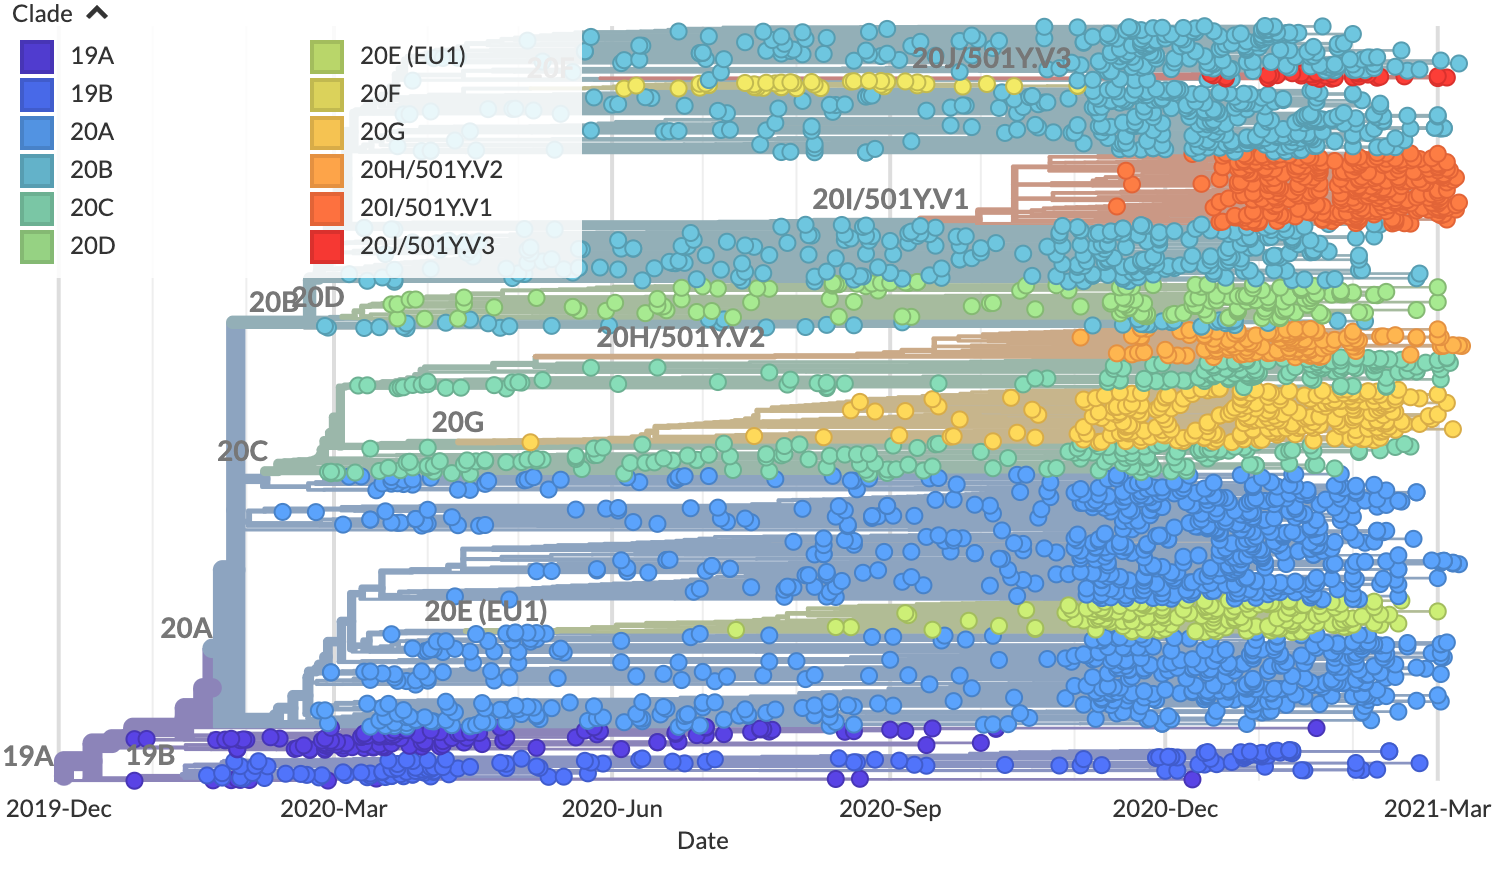

We assume that strains in the same clade share similar phenotypes like their ability to infect specific cells or transmit between hosts.
The rise in frequency of specific clades through time can indicate potentially more pathogenic phenotypes.
We visualize the frequencies of clades through time for SARS-CoV-2, as shown below, to identify and track the evolution of these new phenotypes.

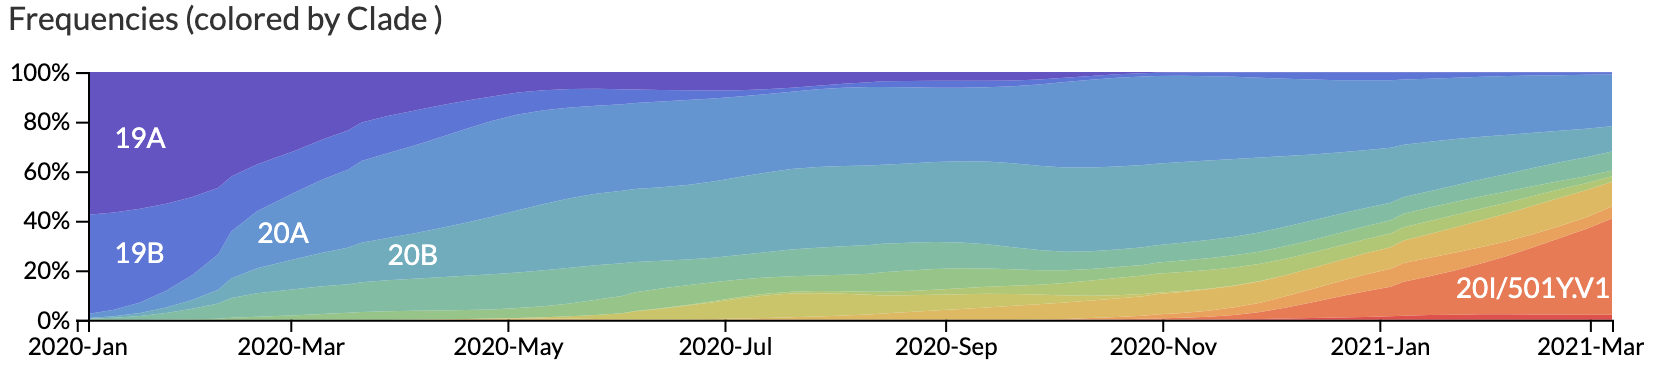

This tutorial shows how to use Nextstrain's precalculated strain frequencies to estimate the frequencies of SARS-CoV-2 clades through time and use that information to identify clades that have risen in frequency rapidly.
By the end of this tutorial you will know:

* how Nextstrain estimates the frequency of individual pathogen strains
* how to calculate the frequency of phylogenetic clades through time
* how to use clade frequencies to identify clades that have recently grown or declined in frequency

To get started, you will need to:

* install Python and Augur
* know how to execute Python commands on from the Python terminal

## Import Python modules

In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

%matplotlib inline

## Get the data

Define the URLs to a phylogeny of a global Nextstrain analysis of SARS-CoV-2 and the precalculated frequencies for each strain in that phylogeny.

In [2]:
tree_url = "https://data.nextstrain.org/ncov_global.json"
frequencies_url = "https://data.nextstrain.org/ncov_global_tip-frequencies.json"

Download precalculated frequencies.

In [3]:
frequencies = requests.get(frequencies_url).json()

Frequencies are stored by strain name.

In [4]:
print(list(frequencies.keys())[:5])

['Afghanistan/IMB07958/2020', 'Afghanistan/IMB07966/2020', 'Afghanistan/IMB15483/2021', 'Afghanistan/IMB15484/2021', 'Afghanistan/IMB15486/2021']


Each strain has a list of frequencies at multiple timepoints from the global analysis.
The following code selects the first strain from the list of all strains, but you can set `strain_name` to any valid strain to see that strain's frequencies.

In [5]:
strain_name = list(frequencies.keys())[0]
print(strain_name)

Afghanistan/IMB07958/2020


In [6]:
print(frequencies[strain_name])

{'frequencies': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-06, 3e-06, 1.4e-05, 5.1e-05, 0.000165, 0.000483, 0.001121, 0.00219, 0.003605, 0.004974, 0.005749, 0.005776, 0.005015, 0.003791, 0.002421, 0.001373, 0.000666, 0.000278, 0.000108, 3.4e-05, 9e-06, 2e-06, 1e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


In addition to strain-specific data, the frequencies data also include the array of timepoints (or "pivots") at which frequencies were originally estimated for each strain. Each position in the array of pivots corresponds to a position in each strain's frequencies array.

In [7]:
print(frequencies["pivots"][:5])

[2020.011, 2020.0301, 2020.0493, 2020.0684, 2020.0861]


We can also learn how these frequencies were originally generated.

In [8]:
print(frequencies["generated_by"])

{'program': 'augur', 'version': '11.2.0'}


Let's export the pivots into their own variable, removing them from the main data structure. We convert them to a numpy array to simplify math and plotting operations later.

In [9]:
pivots = np.array(frequencies.pop("pivots"))

In [10]:
print(pivots)

[2020.011  2020.0301 2020.0493 2020.0684 2020.0861 2020.1052 2020.1244
 2020.1436 2020.1667 2020.1858 2020.205  2020.2242 2020.2433 2020.261
 2020.2801 2020.2993 2020.3184 2020.3388 2020.358  2020.3771 2020.3963
 2020.4155 2020.4331 2020.4523 2020.4714 2020.4906 2020.511  2020.5301
 2020.5493 2020.5684 2020.5861 2020.6052 2020.6244 2020.6436 2020.6627
 2020.6804 2020.6995 2020.7187 2020.7379 2020.7582 2020.7774 2020.7965
 2020.8157 2020.8333 2020.8525 2020.8717 2020.8908 2020.91   2020.9304
 2020.9495 2020.9687 2020.9879 2021.0055 2021.0246 2021.0438 2021.063
 2021.0821 2021.0998 2021.1189 2021.1381 2021.1573 2021.1831]


Let's convert the dictionary of lists to a dictionary of numpy arrays, too.

In [11]:
frequency_arrays = {
    strain: np.array(strain_frequencies["frequencies"])
    for strain, strain_frequencies in frequencies.items()
    if "frequencies" in strain_frequencies
}

## Plot strain frequencies through time

Now, we can plot the frequency of an individual strain over time. This view shows us that each strain's frequencies through time are represented by a normal distribution. This representation is a feature of [the kernel density estimation (KDE) method of frequency estimation in Augur](https://docs.nextstrain.org/projects/augur/en/stable/usage/cli/frequencies.html).

Text(0, 0.5, 'Frequency')

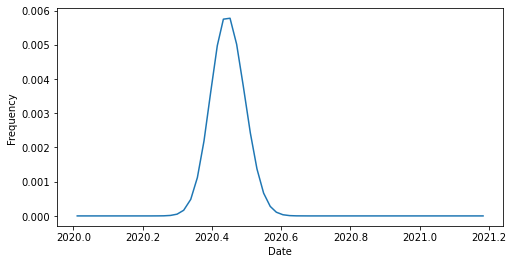

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(
    pivots,
    frequency_arrays[strain_name]
)

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

We can also plot the frequencies of all strains over time at once. This view shows us all of the overlapping normal distributions for each strain. It also shows us the noise (or uncertainty) in frequency estimates at the beginning of 2020 when relatively few SARS-CoV-2 strains had been sampled.

Text(0, 0.5, 'Frequency')

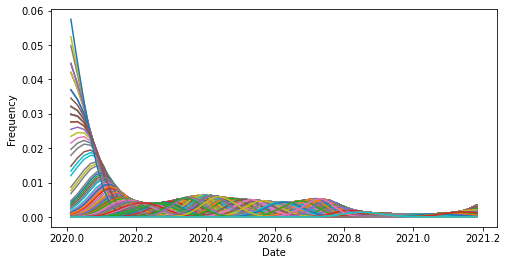

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for strain, strain_frequencies in frequency_arrays.items():
    ax.plot(
        pivots,
        strain_frequencies
    )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

## Estimate clade frequencies through time

In practice, we care about the growth or decline of groups of strains that all share the same mutation(s), or _clades_. Clades are also represented as internal or ancestral nodes of a phylogeny. To calculate the frequencies of clades through time, we need to know which strains belong to each clade which is information provided by the original phylogeny. So, let's download the phylogenetic tree of the strains that we've loaded frequencies for.

In [14]:
tree_json = requests.get(tree_url).json()

On [nextstrain.org](https://nextstrain.org), the tree is a JSON file, but to work with the tree in Python, we need to convert the JSON to a BioPython tree data structure.

In [15]:
tree = json_to_tree(tree_json)

Every inferred ancestral node and observed strain in the tree is represented as a "clade" object with zero or more descendants. This means the root of the tree is a clade, too. Ancestral nodes get their own arbitrary names, so we can perform operations on specific nodes.

In [16]:
print(repr(tree))

Clade(branch_length=0, name='NODE_0000000')


Before we can inspect the frequency of clades over time, we need to calculate the frequency of each clade from its child strain frequencies. The frequency of any clade at a given time is the sum of its child strain frequencies at that time. We'll calculate these clade frequencies in a bottom-up approach, working from each tip up to the root of the tree. For example, we calculate the frequencies of the parents of each strain in the tree as the sum of their immediate children. This approach is also known as a [postorder tree traversal](https://en.wikipedia.org/wiki/Tree_traversal#Post-order,_LRN) and it allows us to calculate the frequencies of all nodes in the tree in a single pass.

In [17]:
for node in tree.find_clades(order="postorder"):
    if node.is_terminal():
        # We already know the frequencies of each terminal node, so
        # store those frequencies with the corresponding node of the tree.
        node.frequencies = frequency_arrays[node.name]
    else:
        # For each internal node, sum the frequencies of its immediate
        # children. Since we are walking through the tree from the bottom
        # up, each child node will always have frequencies calculated
        # before its parent node. Thus, summing the frequencies of the
        # immediate children in postorder gives us the sum of the frequencies
        # of all children of a node (not just the immediate ones).
        node.frequencies = np.array([
            child.frequencies
            for child in node.clades
        ]).sum(axis=0)

The root node of the tree should always be at 100% frequency. We can see that this is generally true, within the bounds of some rounding error.

In [18]:
tree.root.frequencies

array([1.000001, 0.999976, 0.999992, 0.999988, 1.000006, 1.000002,
       0.999984, 0.999995, 0.999993, 1.000007, 0.999979, 1.000007,
       1.000003, 0.999979, 0.999979, 0.999984, 0.999962, 0.999983,
       0.999953, 1.000006, 1.000008, 0.99996 , 0.99999 , 1.000022,
       0.999964, 0.999966, 1.000004, 1.000007, 1.000015, 0.999969,
       0.999994, 0.999968, 0.999974, 0.999979, 0.999962, 0.999912,
       0.999957, 0.999999, 1.000012, 0.99999 , 0.999854, 0.999941,
       0.999937, 0.999995, 0.999904, 0.999944, 0.99991 , 0.999979,
       0.99992 , 0.999943, 1.000061, 0.999974, 0.999973, 0.999882,
       1.000104, 0.999916, 0.999869, 1.000042, 0.999852, 0.999916,
       1.000003, 1.000119])

Now, we can investigate the frequency of different clades through time. In addition to strain names, each node of the tree also carries annotations like clade membership.  Here, clade membership refers to the Nextstrain clade names, which label major clades of potential epidemiological significance. We can use these annotations to identify the most ancestral node for each major clade. Then we can plot the frequencies of these major clades through time.

In [19]:
clade_nodes_by_name = {}
for node in tree.find_clades(terminal=False):
    if "clade_membership" in node.node_attrs:
        clade_name = node.node_attrs["clade_membership"]["value"]

        if clade_name not in clade_nodes_by_name:
            clade_nodes_by_name[clade_name] = node

From the list below, we see that we found all major clades annotated in the tree.

In [20]:
print(clade_nodes_by_name.keys())

dict_keys(['19A', '19B', '20A', '20E (EU1)', '20C', '20G', '20H/501Y.V2', '20B', '20D', '20I/501Y.V1', '20F', '20J/501Y.V3'])


Let's plot the frequency of the clade 20A through time.

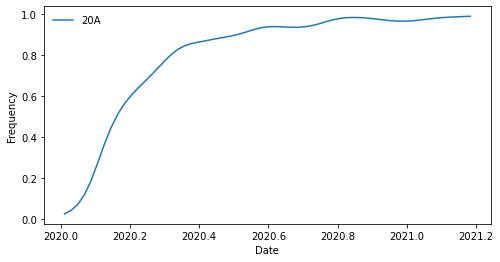

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(
    pivots,
    clade_nodes_by_name["20A"].frequencies,
    label="20A"
)

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend(frameon=False)

Now that we know what to expect, we can plot all clades at once.

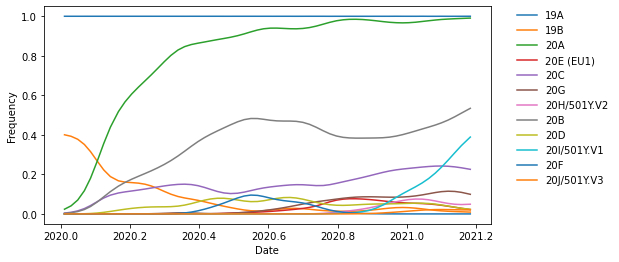

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for clade_name, clade_node in clade_nodes_by_name.items():
    ax.plot(
        pivots,
        clade_node.frequencies,
        label=clade_name
    )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

We can also investigate the frequencies of clades that carry a specific mutation. As an example, let's find all clades that carry the S:484K mutation. Each node in the tree also carries information about the mutations that occurred on the branch leading to that node. Here, we will look at all clades, not just the ones annotated with a Nextstrain clade label.

In [23]:
for node in tree.find_clades():
    if hasattr(node, "branch_attrs") and len(node.branch_attrs.get("mutations", {})) > 0:
        print(f"Node {node.name} has the following branch attributes:")
        print(node.branch_attrs)
        break

Node Wuhan/WH01/2019 has the following branch attributes:
{'labels': {'aa': 'ORF1a: L2235I, N3833K'}, 'mutations': {'ORF1a': ['L2235I', 'N3833K'], 'nuc': ['C6968A', 'T11764A']}}


Use this branch-specific information to find all ancestral nodes with a S:484K mutation on their preceding branch.

In [24]:
clade_nodes_with_484K_by_name = {}
for node in tree.find_clades(terminal=False):
    if (hasattr(node, "branch_attrs") and
        "mutations" in node.branch_attrs and 
        "S" in node.branch_attrs["mutations"] and 
        any([mutation.endswith("484K") for mutation in node.branch_attrs["mutations"]["S"]])):
        if node.name not in clade_nodes_by_name:
            clade_nodes_with_484K_by_name[node.name] = node

We found multiple clades with a S:484K mutation. Since these clades don't necessarily have official names, we will use their internal names for now. In practice, we may want to name these clades after the specific mutations on the branch leading to each clade.

In [25]:
print(clade_nodes_with_484K_by_name.keys())

dict_keys(['NODE_0000610', 'NODE_0000881', 'NODE_0000871', 'NODE_0001119', 'NODE_0001363', 'NODE_0002520', 'NODE_0003571', 'NODE_0003006', 'NODE_0003606', 'NODE_0003639'])


Now, we can plot the frequencies of those clades.

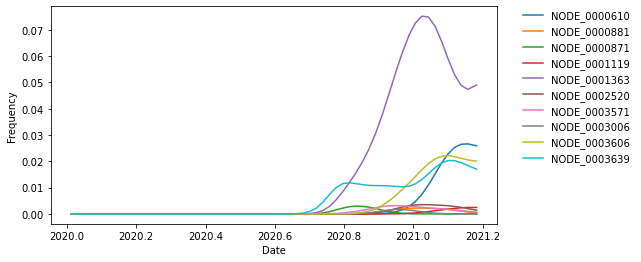

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for clade_name, clade_node in clade_nodes_with_484K_by_name.items():
    ax.plot(
        pivots,
        clade_node.frequencies,
        label=clade_name
    )

ax.set_xlabel("Date")
ax.set_ylabel("Frequency")

ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

## Calculate change in frequency over time per clade

In addition to observing the frequencies of clades through time, we also want to calculate how much each clade has changed in frequency recently. This measure is an indication of growth or decline. Rapidly growing clades may indicate potential variants of concern.

We calculate frequencies at weekly intervals, such that "pivots" are spaced by one week. To find the change in frequency of clades over the last month, we need to compare the most recent frequency of each clade to the frequency four pivots previous. We'll calculate this change in frequency (or "delta frequency") for each major clade.

In [27]:
delta_frequencies = []
for clade_name, clade_node in clade_nodes_by_name.items():
    delta_frequency = clade_node.frequencies[-1] - clade_node.frequencies[-5]
    delta_frequencies.append({
        "clade_name": clade_name,
        "delta_frequency": delta_frequency
    })

Convert the delta frequencies to a pandas DataFrame for easily manipulation and visualization.

In [28]:
delta_frequencies_df = pd.DataFrame(delta_frequencies)

List clades by change in frequency in descending order.

In [29]:
delta_frequencies_df.sort_values("delta_frequency", ascending=False)

,clade_name,delta_frequency
9,20I/501Y.V1,0.152523
7,20B,0.073556
2,20A,0.006957
0,19A,0.000077
10,20F,0.000000
11,20J/501Y.V3,-0.002099
1,19B,-0.006255
6,20H/501Y.V2,-0.010157
5,20G,-0.013409
4,20C,-0.016833


We can repeat the steps above for all clades in the tree, not just those with Nextstrain clade names.
This analysis shows us which clades have changed the most in frequency anywhere in the tree.
We will focus on clades with at least one amino acid mutation on the branch leading to the clade's first ancestral node.

In [30]:
all_delta_frequencies = []

# Inspect all ancestral nodes in the tree.
for node in tree.find_clades(terminal=False):
    # Skip nodes without branch attribute annotations.
    if not hasattr(node, "branch_attrs"):
        continue

    # Skip nodes without any mutations.
    if len(node.branch_attrs["mutations"]) == 0:
        continue

    # Skip nodes with only nucleotide mutations (no amino acid mutations).
    if set(node.branch_attrs["mutations"].keys()) == {"nuc"}:
        continue

    # Convert mutations to a human-readable list.
    mutations = []
    for gene, gene_mutations in node.branch_attrs["mutations"].items():
        if gene != "nuc":
            for mutation in gene_mutations:
                mutations.append(f"{gene}:{mutation}")
    
    mutation_list = ",".join(mutations)
    
    # Calculate the change in frequency over the last four weeks.
    delta_frequency = node.frequencies[-1] - node.frequencies[-5]
    all_delta_frequencies.append({
        "clade_name": node.name,
        "mutations": mutation_list,
        "delta_frequency": delta_frequency
    })

As before, we convert this list of records into a DataFrame and then view the top 10 clades by increased frequency.

In [31]:
all_delta_frequencies_df = pd.DataFrame(all_delta_frequencies)

In [32]:
all_delta_frequencies_df.sort_values("delta_frequency", ascending=False).head(10)

,clade_name,mutations,delta_frequency
903,NODE_0003085,"S:A570D,S:P681H,S:D1118H",0.152192
900,NODE_0003082,"N:S235F,ORF1a:A1708D,ORF1a:I2230T,ORF1a:S3675-...",0.151538
899,NODE_0003081,ORF1a:T1001I,0.151526
902,NODE_0003084,ORF8:R52I,0.151515
901,NODE_0003083,"ORF8:Q27*,ORF8:Y73C,S:T716I",0.151424
905,NODE_0003089,N:D3L,0.149269
726,NODE_0002321,"N:R203K,N:G204R",0.073556
952,NODE_0003104,ORF8:K68*,0.054308
959,NODE_0003143,ORF3a:W131C,0.032203
339,NODE_0002252,"ORF1a:T1168I,ORF1a:P1640L,S:N439K",0.029591
